##Transfer learning with TensorFlow Hub

TensorFlow Hub是一种共享预训练模型组件的方法。有关预训练模型的可搜索列表，请参见TensorFlow模块中心。本教程演示：

1. TensorFlow Hub如何与结合使用tf.keras。
2. 如何使用TensorFlow Hub进行图像分类
3. 如何做简单的迁移学习。
###设定

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import,division,print_function,unicode_literals
import matplotlib.pyplot as plt
import tensorflow as tf


In [0]:
#!pip install -q -U tf-hub-nightly
#!pip install -q tfds-nightly
import tensorflow_hub as hub
from tensorflow.keras import layers

##ImageNet分类器
###下载分类器
使用`hub.module`加载`mobilenet`，并`tf.keras.layers.Lambda`包裹起来作为keras层。来自`tfhub.dev`的任何与TensorFlow 2兼容的图像分类器URL都将在这里工作。

In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [0]:
IMAGE_SHAPE = (224,224)

classifier = tf.keras.Sequential([
  hub.KerasLayer(classifier_url,input_shape=IMAGE_SHAPE+(3,))
])

In [0]:
(3,)+IMAGE_SHAPE

(3, 224, 224)

In [0]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

###在单个图像上运行
下载单个图像以尝试模型。

65536/61306 [================================] - 0s 0us/step


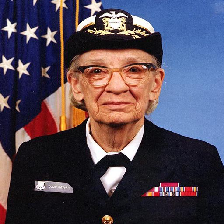

In [0]:
import numpy as np
import PIL.Image as Image 

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [0]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

添加批次尺寸，然后将图像传递给模型。

In [0]:
result = classifier.predict(grace_hopper[np.newaxis,...])
result.shape

(1, 1001)

结果是logit的1001元素向量，对图像的每个类别的概率进行评级。

因此，可以使用argmax找到顶级类ID：

In [0]:
predicted_class = np.argmax(result[0],axis=-1)
predicted_class

653

In [0]:
result

array([[ 0.17920303,  1.2696182 , -0.3149821 , ...,  0.6060541 ,
        -0.4299778 ,  0.11200593]], dtype=float32)

###解码预测
我们具有预测的类ID，获取ImageNet标签并解码预测

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


In [0]:
imagenet_labels.shape

(1001,)

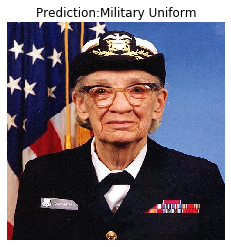

In [0]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction:"+predicted_class_name.title())

###简单的转移学习
使用TF Hub，可以很容易地重新训练模型的顶层，以识别数据集中的类。

####数据集
在此示例中，您将使用TensorFlow flowers数据集：

In [0]:
data_root = tf.keras.utils.get_file(
    'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)

228818944/228813984 [==============================] - 1s 0us/step


将此数据加载到模型中的最简单方法是使用tf.keras.preprocessing.image.ImageDataGenerator，

所有的TensorFlow枢纽的形象模块预计浮法输入[0, 1]范围。使用ImageDataGenerator的rescale参数可实现此目的。

图像尺寸将在以后处理。

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root),target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


结果对象是返回image_batch, label_batch对的迭代器。

In [0]:
for image_batch,label_batch in image_data:
  print("Image batch shape:",image_batch.shape)
  print("Label batch shape:",label_batch.shape)
  break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 5)


###在一批图像上运行分类器
现在在图像批处理上运行分类器。

In [0]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [0]:
predicted_class_names = imagenet_labels[np.argmax(result_batch,axis=-1)]
predicted_class_names

array(['daisy', 'sea urchin', 'daisy', 'daisy', 'porcupine', 'daisy',
       'hip', 'fountain', 'daisy', 'red wine', 'daisy', 'corn',
       'picket fence', 'cardoon', 'daisy', 'daisy', 'daisy', 'daisy',
       'stone wall', 'daisy', 'picket fence', 'ice cream', 'hip',
       'feather boa', 'daisy', 'daisy', 'daisy', 'coral fungus',
       'stone wall', 'daisy', 'daisy', 'picket fence'], dtype='<U30')

现在检查这些预测如何与图像对齐：

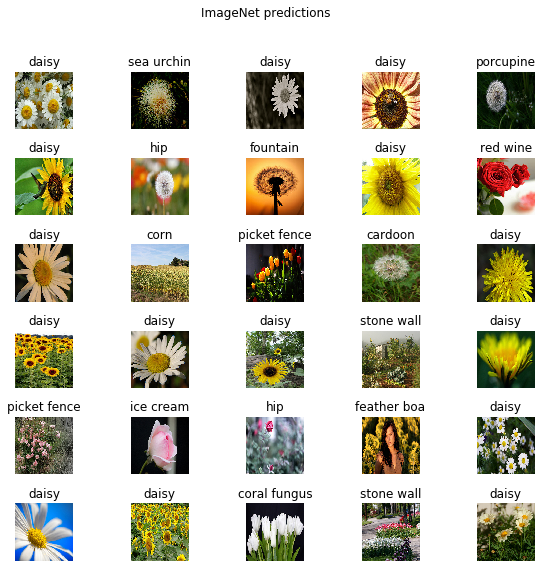

In [0]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis("off")
_ = plt.suptitle("ImageNet predictions")

请参阅`LICENSE.txt`文件以获取图像归因。

结果远非完美，但考虑到这些不是模型训练的类别（“雏菊”除外），这是合理的。

###下载无头模型
TensorFlow Hub还可以分发没有顶层分类层的模型。这些可以用来轻松进行转移学习。

来自tfhub.dev的任何与Tensorflow 2兼容的图像特征矢量URL都可在此处使用。

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

创建特征提取器。

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

创建特征提取器。

In [0]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


在特征提取器层中冻结变量，以便训练仅修改新的分类器层。

In [0]:
feature_extractor_layer.trainable = False

###附上分类头
现在将中心层包装在tf.keras.Sequential模型中，并添加一个新的分类层。

In [0]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes,activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

In [0]:
predictions.shape

TensorShape([32, 5])

###训练模型
使用编译来配置训练过程：

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['acc']
)

现在使用该.fit方法训练模型。

为了使该示例短时训练仅2个纪元。要可视化训练进度，请使用自定义回调来分别记录每个批次的损失和准确性，而不是历时平均值。

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self,batch,logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [0]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data,epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks=[batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 115.0 steps
Epoch 1/2
115/115 [==============================] - 15s 127ms/step - loss: 0.6734 - acc: 0.9062
Epoch 2/2
115/115 [==============================] - 12s 106ms/step - loss: 0.3391 - acc: 0.8438


现在，即使只是几次训练迭代，我们已经可以看到模型在任务上取得了进展。

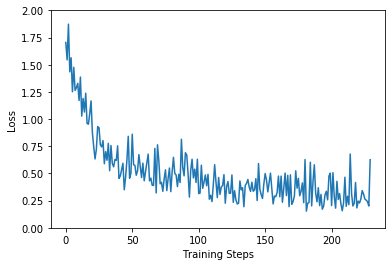

In [0]:
plt.figure()
plt.ylabel('Loss')
plt.xlabel('Training Steps')
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

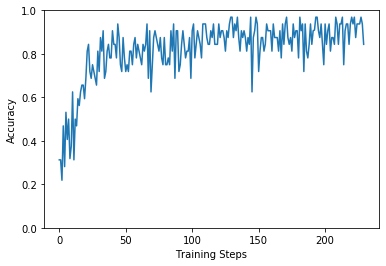

In [0]:
plt.figure()
plt.ylabel('Accuracy')
plt.xlabel('Training Steps')
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

###检查预测
要重做之前的图，请首先获取类名称的有序列表：

In [0]:
class_names = sorted(image_data.class_indices.items(),key=lambda pair:pair[1])
class_names = np.array([key.title() for key,value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

通过模型运行图像批处理并将索引转换为类名称。

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch,axis=-1)
predicted_label_batch = class_names[predicted_id]

绘制结果

In [0]:
label_id = np.argmax(label_batch,axis=-1)

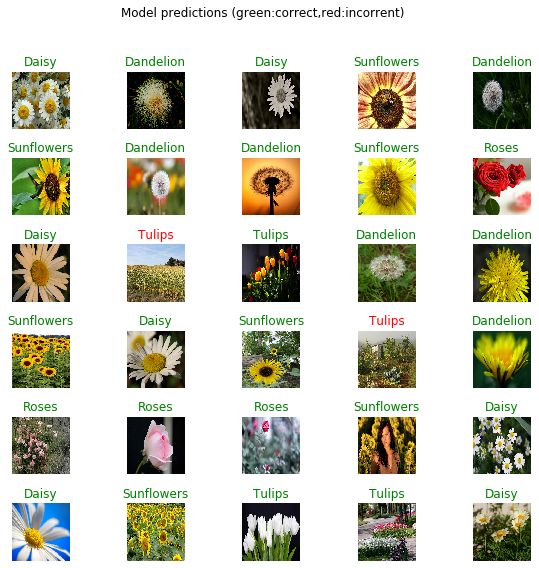

In [0]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = 'green' if predicted_id[n] == label_id[n] else 'red'
  plt.title(predicted_label_batch[n].title(),color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green:correct,red:incorrent)")

###导出模型
现在您已经训练了模型，将其导出为保存的模型：

In [0]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path,save_format='tf')

export_path

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1580443194/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1580443194/assets


'/tmp/saved_models/1580443194'

现在确认我们可以重新加载它，并且仍然得到相同的结果：

In [0]:
reloaded = tf.keras.models.load_model(export_path)

In [0]:
result_batch = model.predict(image_batch)#原来模型预测
reloaded_result_batch = reloaded.predict(image_batch)#新加载模型预测

In [0]:
abs(reloaded_result_batch - result_batch).max()

0.0

可以加载此保存的模型以供以后推断，或转换为[TFLite](https://www.tensorflow.org/lite/convert/)或[TFjs](https://github.com/tensorflow/tfjs-converter)。